# Cell 1 — Dataset Path Configuration

In [26]:
# ============================================================
#  DATASET PATH — Edit this to match your Kaggle input path
# ============================================================

DATA_DIR = '/kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer'

# ============================================================
#  TRAINING PARAMETERS (keep consistent with Task 2 notebooks)
# ============================================================
IMAGE_SIZE   = 224       # Input image size
BATCH_SIZE   = 32        # Batch size
NUM_EPOCHS   = 10        # Epochs
LEARNING_RATE = 0.001    # Learning rate
TRAIN_RATIO  = 0.7       # 70% train
VAL_RATIO    = 0.15      # 15% val
TEST_RATIO   = 0.15      # 15% test
RANDOM_SEED  = 42        # Fixed seed for reproducibility

print("Dataset path:", DATA_DIR)
print("Image size  :", IMAGE_SIZE)
print("Batch size  :", BATCH_SIZE)
print("Epochs      :", NUM_EPOCHS)
print("Seed        :", RANDOM_SEED)

Dataset path: /kaggle/input/datasets/obulisainaren/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer
Image size  : 224
Batch size  : 32
Epochs      : 10
Seed        : 42


#  Cell 2 — Imports

In [27]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel

# ── Reproducibility ──────────────────────────────────────────
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Cell 3 — Dataset Loading & Splitting

In [28]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
class_names  = full_dataset.classes
num_classes  = len(class_names)
n_total      = len(full_dataset)

print(f"Classes ({num_classes}): {class_names}")
print(f"Total samples : {n_total}")

# ── Stratified split (same split for all models) ─────────────
indices = list(range(n_total))
labels  = [full_dataset.targets[i] for i in indices]

train_idx, temp_idx = train_test_split(
    indices, test_size=(VAL_RATIO + TEST_RATIO),
    stratify=labels, random_state=RANDOM_SEED)

temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    stratify=temp_labels, random_state=RANDOM_SEED)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Subset(full_dataset, val_idx),   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Subset(full_dataset, test_idx),  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train : {len(train_idx)} | Val : {len(val_idx)} | Test : {len(test_idx)}")

Classes (3): ['brain_glioma', 'brain_menin', 'brain_tumor']
Total samples : 15000
Train : 10500 | Val : 2250 | Test : 2250


# Cell 4 — Helper: Train & Evaluate a Model

In [29]:
def train_model(model, train_loader, val_loader, num_epochs, lr):
    """Fine-tune model, return trained model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    model.to(device)
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(num_epochs):
        # ── Train ──
        model.train()
        running_loss, running_correct = 0.0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss    += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()

        train_acc  = running_correct / len(train_loader.dataset)

        # ── Validate ──
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_correct += (outputs.argmax(1) == targets).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = {k: v.clone() for k, v in model.state_dict().items()}

        scheduler.step()
        print(f"  Epoch [{epoch+1:02d}/{num_epochs}] "
              f"Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    return model


def get_per_sample_correctness(model, loader):
    """
    Returns a binary numpy array of length = test set size.
    1 = correctly classified, 0 = misclassified.
    """
    model.eval()
    correct_flags = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs).argmax(dim=1)
            correct_flags.extend((preds == targets).cpu().numpy().astype(int))
    return np.array(correct_flags)


print("Helper functions defined.")

Helper functions defined.


# Cell 5 — Model 1: ResNet-50

In [30]:
print("="*50)
print("MODEL 1: ResNet-50")
print("="*50)

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace final FC layer
in_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

t0_resnet = time.time()
resnet = train_model(resnet, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
train_time_resnet = time.time() - t0_resnet

t0 = time.time()
correctness_resnet = get_per_sample_correctness(resnet, test_loader)
test_time_resnet = time.time() - t0

acc_resnet = correctness_resnet.mean()
print(f"\nResNet-50  Test Accuracy : {acc_resnet:.4f}")
print(f"Training time : {train_time_resnet/60:.2f} min | Testing time : {test_time_resnet:.2f} sec")

MODEL 1: ResNet-50
  Epoch [01/10] Train Acc: 0.8285  Val Acc: 0.9160
  Epoch [02/10] Train Acc: 0.8894  Val Acc: 0.9164
  Epoch [03/10] Train Acc: 0.8951  Val Acc: 0.9369
  Epoch [04/10] Train Acc: 0.9111  Val Acc: 0.9409
  Epoch [05/10] Train Acc: 0.9078  Val Acc: 0.9187
  Epoch [06/10] Train Acc: 0.9250  Val Acc: 0.9418
  Epoch [07/10] Train Acc: 0.9323  Val Acc: 0.9431
  Epoch [08/10] Train Acc: 0.9346  Val Acc: 0.9449
  Epoch [09/10] Train Acc: 0.9321  Val Acc: 0.9453
  Epoch [10/10] Train Acc: 0.9359  Val Acc: 0.9489

ResNet-50  Test Accuracy : 0.9351
Training time : 7.19 min | Testing time : 7.77 sec


# Cell 6 — Model 2: VGG-16

In [31]:
print("="*50)
print("MODEL 2: VGG-16")
print("="*50)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replace classifier head
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

t0_vgg = time.time()
vgg16 = train_model(vgg16, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
train_time_vgg = time.time() - t0_vgg

t0 = time.time()
correctness_vgg = get_per_sample_correctness(vgg16, test_loader)
test_time_vgg = time.time() - t0

acc_vgg = correctness_vgg.mean()
print(f"\nVGG-16  Test Accuracy : {acc_vgg:.4f}")
print(f"Training time : {train_time_vgg/60:.2f} min | Testing time : {test_time_vgg:.2f} sec")

MODEL 2: VGG-16
  Epoch [01/10] Train Acc: 0.8718  Val Acc: 0.9529
  Epoch [02/10] Train Acc: 0.9455  Val Acc: 0.9698
  Epoch [03/10] Train Acc: 0.9570  Val Acc: 0.9689
  Epoch [04/10] Train Acc: 0.9667  Val Acc: 0.9760
  Epoch [05/10] Train Acc: 0.9782  Val Acc: 0.9698
  Epoch [06/10] Train Acc: 0.9895  Val Acc: 0.9787
  Epoch [07/10] Train Acc: 0.9939  Val Acc: 0.9822
  Epoch [08/10] Train Acc: 0.9962  Val Acc: 0.9804
  Epoch [09/10] Train Acc: 0.9972  Val Acc: 0.9827
  Epoch [10/10] Train Acc: 0.9967  Val Acc: 0.9822

VGG-16  Test Accuracy : 0.9796
Training time : 7.86 min | Testing time : 8.17 sec


# Cell 7 — Model 3: EfficientNet-B0

In [32]:
print("="*50)
print("MODEL 3: EfficientNet-B0")
print("="*50)

efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze all feature layers
for param in efficientnet.features.parameters():
    param.requires_grad = False

# Replace classifier head
in_features_eff = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features_eff, num_classes)
)

t0_eff = time.time()
efficientnet = train_model(efficientnet, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
train_time_eff = time.time() - t0_eff

t0 = time.time()
correctness_eff = get_per_sample_correctness(efficientnet, test_loader)
test_time_eff = time.time() - t0

acc_eff = correctness_eff.mean()
print(f"\nEfficientNet-B0  Test Accuracy : {acc_eff:.4f}")
print(f"Training time : {train_time_eff/60:.2f} min | Testing time : {test_time_eff:.2f} sec")

MODEL 3: EfficientNet-B0
  Epoch [01/10] Train Acc: 0.8556  Val Acc: 0.9271
  Epoch [02/10] Train Acc: 0.8984  Val Acc: 0.9418
  Epoch [03/10] Train Acc: 0.9031  Val Acc: 0.9480
  Epoch [04/10] Train Acc: 0.9072  Val Acc: 0.9489
  Epoch [05/10] Train Acc: 0.9099  Val Acc: 0.9516
  Epoch [06/10] Train Acc: 0.9145  Val Acc: 0.9560
  Epoch [07/10] Train Acc: 0.9107  Val Acc: 0.9529
  Epoch [08/10] Train Acc: 0.9159  Val Acc: 0.9502
  Epoch [09/10] Train Acc: 0.9108  Val Acc: 0.9533
  Epoch [10/10] Train Acc: 0.9139  Val Acc: 0.9516

EfficientNet-B0  Test Accuracy : 0.9489
Training time : 6.86 min | Testing time : 7.54 sec


# Cell 8 — Paired T-Test: All Three Model Pairs

In [33]:
from scipy.stats import ttest_rel

print("="*60)
print("PAIRED T-TEST RESULTS (α = 0.05)")
print("="*60)
print(f"{'Comparison':<35} {'t-stat':>10} {'p-value':>12} {'Significant?':>14}")
print("-"*60)

pairs = [
    ("ResNet-50",      correctness_resnet, "VGG-16",         correctness_vgg),
    ("ResNet-50",      correctness_resnet, "EfficientNet-B0", correctness_eff),
    ("VGG-16",         correctness_vgg,    "EfficientNet-B0", correctness_eff),
]

ttest_results = []

for name_a, vec_a, name_b, vec_b in pairs:
    t_stat, p_val = ttest_rel(vec_a, vec_b)
    significant   = "Yes ✅" if p_val < 0.05 else "No ❌"
    label         = f"{name_a} vs {name_b}"
    print(f"{label:<35} {t_stat:>10.4f} {p_val:>12.6f} {significant:>14}")
    ttest_results.append({
        "Comparison": label,
        "t-statistic": round(t_stat, 6),
        "p-value":     round(p_val,  6),
        "Significant (α=0.05)": significant
    })

print("="*60)
print("\nNote: A p-value < 0.05 means the performance difference")
print("between the two models is statistically significant.")

df_ttest = pd.DataFrame(ttest_results)
df_ttest

PAIRED T-TEST RESULTS (α = 0.05)
Comparison                              t-stat      p-value   Significant?
------------------------------------------------------------
ResNet-50 vs VGG-16                    -8.9944     0.000000          Yes ✅
ResNet-50 vs EfficientNet-B0           -2.4929     0.012743          Yes ✅
VGG-16 vs EfficientNet-B0               6.7359     0.000000          Yes ✅

Note: A p-value < 0.05 means the performance difference
between the two models is statistically significant.


,Comparison,t-statistic,p-value,Significant (α=0.05)
0,ResNet-50 vs VGG-16,-8.994403,0.000000,Yes ✅
1,ResNet-50 vs EfficientNet-B0,-2.492864,0.012743,Yes ✅
2,VGG-16 vs EfficientNet-B0,6.735936,0.000000,Yes ✅


# Cell 9 — Summary Accuracy Table

In [34]:
summary_data = {
    "Model": ["ResNet-50", "VGG-16", "EfficientNet-B0"],
    "Test Accuracy": [
        round(float(acc_resnet), 4),
        round(float(acc_vgg),    4),
        round(float(acc_eff),    4)
    ],
    "Train Time (min)": [
        round(train_time_resnet / 60, 2),
        round(train_time_vgg    / 60, 2),
        round(train_time_eff    / 60, 2)
    ],
    "Test Time (sec)": [
        round(test_time_resnet, 2),
        round(test_time_vgg,   2),
        round(test_time_eff,   2)
    ]
}

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))
df_summary

          Model  Test Accuracy  Train Time (min)  Test Time (sec)
      ResNet-50         0.9351              7.19             7.77
         VGG-16         0.9796              7.86             8.17
EfficientNet-B0         0.9489              6.86             7.54


,Model,Test Accuracy,Train Time (min),Test Time (sec)
0,ResNet-50,0.9351,7.19,7.77
1,VGG-16,0.9796,7.86,8.17
2,EfficientNet-B0,0.9489,6.86,7.54


# Cell 10 — Visualizations

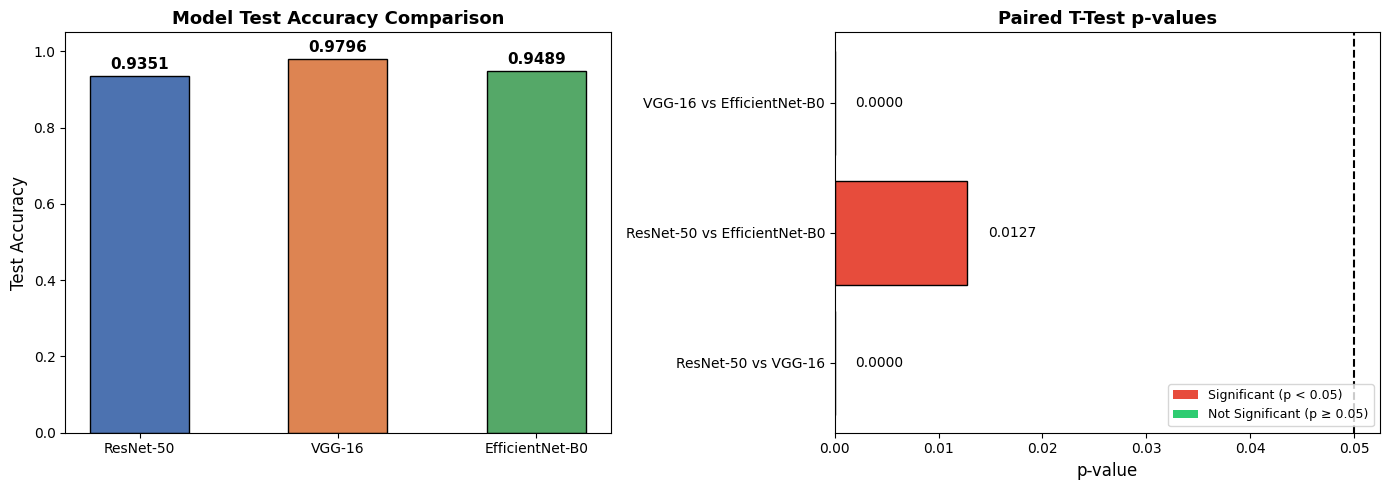

Figure saved as ttest_comparison.png


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Plot 1: Test Accuracy Bar Chart ──────────────────────────
models_names = ["ResNet-50", "VGG-16", "EfficientNet-B0"]
accuracies   = [float(acc_resnet), float(acc_vgg), float(acc_eff)]
colors       = ["#4C72B0", "#DD8452", "#55A868"]

bars = axes[0].bar(models_names, accuracies, color=colors, edgecolor='black', width=0.5)
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel("Test Accuracy", fontsize=12)
axes[0].set_title("Model Test Accuracy Comparison", fontsize=13, fontweight='bold')
for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{acc:.4f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

# ── Plot 2: Paired T-Test p-values ───────────────────────────
comparisons = [r["Comparison"] for r in ttest_results]
p_values    = [r["p-value"]    for r in ttest_results]
bar_colors  = ["#e74c3c" if p < 0.05 else "#2ecc71" for p in p_values]

hbars = axes[1].barh(comparisons, p_values, color=bar_colors, edgecolor='black')
axes[1].axvline(x=0.05, color='black', linestyle='--', linewidth=1.5, label='α = 0.05 threshold')
axes[1].set_xlabel("p-value", fontsize=12)
axes[1].set_title("Paired T-Test p-values", fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
for bar, pv in zip(hbars, p_values):
    axes[1].text(pv + 0.002, bar.get_y() + bar.get_height()/2,
                 f"{pv:.4f}", va='center', fontsize=10)

# legend labels
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Significant (p < 0.05)'),
                   Patch(facecolor='#2ecc71', label='Not Significant (p ≥ 0.05)')]
axes[1].legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig("ttest_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved as ttest_comparison.png")

# Cell 11 — Per-Sample Correctness Heatmap (Sample View)

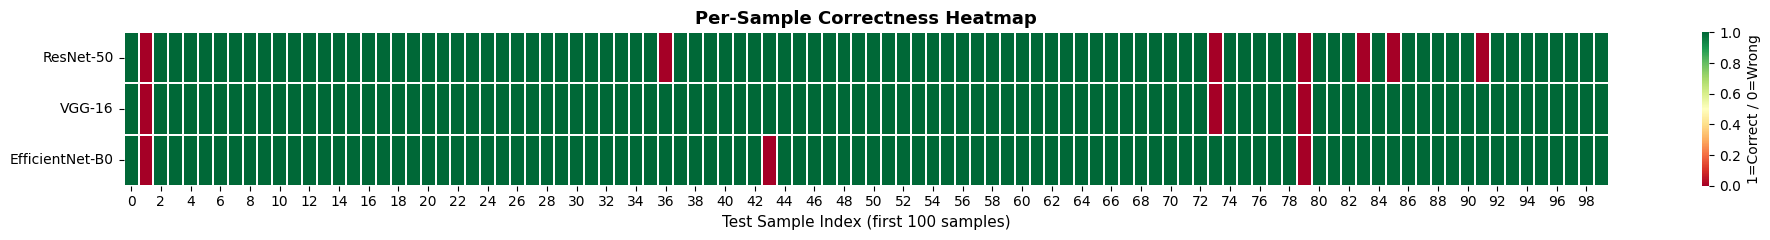

Heatmap saved as correctness_heatmap.png


In [36]:
# Show correctness vectors side by side for first 100 test samples
n_show = min(100, len(correctness_resnet))

correctness_matrix = np.vstack([
    correctness_resnet[:n_show],
    correctness_vgg   [:n_show],
    correctness_eff   [:n_show]
]).astype(float)

fig, ax = plt.subplots(figsize=(20, 2.5))
sns.heatmap(
    correctness_matrix,
    ax=ax,
    cmap="RdYlGn",
    vmin=0, vmax=1,
    linewidths=0.1,
    cbar_kws={"label": "1=Correct / 0=Wrong"},
    yticklabels=["ResNet-50", "VGG-16", "EfficientNet-B0"]
)
ax.set_xlabel(f"Test Sample Index (first {n_show} samples)", fontsize=11)
ax.set_title("Per-Sample Correctness Heatmap", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("correctness_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()
print("Heatmap saved as correctness_heatmap.png")

# Cell 12 — Final Interpretation & Conclusion

In [37]:
print("=" * 65)
print("FINAL PAIRED T-TEST SUMMARY")
print("=" * 65)
print()
print(f"{'Model':<20} {'Accuracy':>10}")
print("-" * 32)
for name, acc in zip(models_names, accuracies):
    print(f"{name:<20} {acc:>10.4f}")

print()
print("Paired T-Test Results (significance level α = 0.05):")
print("-" * 65)
for r in ttest_results:
    print(f"  {r['Comparison']:<35}  "
          f"t={r['t-statistic']:>8.4f}   "
          f"p={r['p-value']:>8.6f}   "
          f"{r['Significant (α=0.05)']}")

print()
print("Interpretation:")
for r in ttest_results:
    is_sig = r['p-value'] < 0.05
    conclusion = (
        f"→ {r['Comparison']}: The difference IS statistically significant "
        f"(p={r['p-value']:.4f} < 0.05)."
        if is_sig else
        f"→ {r['Comparison']}: The difference is NOT statistically significant "
        f"(p={r['p-value']:.4f} ≥ 0.05)."
    )
    print(conclusion)

best_model = models_names[np.argmax(accuracies)]
print(f"\nBest performing model: {best_model} ({max(accuracies):.4f} accuracy)")
print("=" * 65)

FINAL PAIRED T-TEST SUMMARY

Model                  Accuracy
--------------------------------
ResNet-50                0.9351
VGG-16                   0.9796
EfficientNet-B0          0.9489

Paired T-Test Results (significance level α = 0.05):
-----------------------------------------------------------------
  ResNet-50 vs VGG-16                  t= -8.9944   p=0.000000   Yes ✅
  ResNet-50 vs EfficientNet-B0         t= -2.4929   p=0.012743   Yes ✅
  VGG-16 vs EfficientNet-B0            t=  6.7359   p=0.000000   Yes ✅

Interpretation:
→ ResNet-50 vs VGG-16: The difference IS statistically significant (p=0.0000 < 0.05).
→ ResNet-50 vs EfficientNet-B0: The difference IS statistically significant (p=0.0127 < 0.05).
→ VGG-16 vs EfficientNet-B0: The difference IS statistically significant (p=0.0000 < 0.05).

Best performing model: VGG-16 (0.9796 accuracy)
